<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/colaborative-filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"f045f4a4adb9707f5c86d18bc28608b2"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar  8 07:14 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          13564  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          40404  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25           9699  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           2361  
mohansacharya/graduate-admissions                         

In [8]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

the-movies-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
tmdb-movie-metadata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ratings_small.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace links_small.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace keywords.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [13]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

In [15]:
!sudo pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 8.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
def load_tmdb_movies(path):
  df = pd.read_csv(path)
  df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
  json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
  for column in json_columns:
    df[column] = df[column].apply(json.loads)
  return df
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
def safe_access(container, index_values):
  result  = container
  try:
    for idx in index_values:
      result = result[idx]
    return result
  except IndexError or KeyError:
    return pd.np.nan
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
def pipe_flatten_names(keywords):
  return "|".join(x['name'] for x in keywords)

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

def convert_to_original_format(movies, credits):
  tmdb_movies = movies.copy()
  tmdb_movies.rename(columns= TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace = True)
  tmdb_movies['title_years']= pd.to_datetime(tmdb_movies['release_date']).apply(lambda x:x.year)
  tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
  tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x,[0,'name']))
  
  tmdb_movies['director_name'] = credits['crew'].apply(get_director)
  tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
  tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
  tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
  tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
  tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
  return tmdb_movies

In [17]:
convert_to_original_format(load_tmdb_movies('tmdb_5000_movies.csv'),load_tmdb_credits('tmdb_5000_credits.csv'))


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,The battle within.,Spider-Man 3,5.9,3576,2007.0,United States of America,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,They're taking adventure to new lengths.,Tangled,7.4,3330,2010.0,United States of America,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,Dav

In [18]:
!pip install fuzzywuzzy

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))

Shape: (4803, 26)


In [24]:
tab_info

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [0]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): 
      # neu liste
      continue 
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

def count_word(df, ref_col, liste):
  keyword_count = dict()
  for s in liste:
    keyword_count[s] = 0
  for liste_keywords in df[ref_col].str.split("|"):
    if type(liste_keywords) == float and pd.isnull(liste_keywords):
      continue
#     temp = []
#     for s in temp:
#       for s in liste_keywords:
#         if s in liste:
#           temp.append(s)
#           if pd.notnull(s): 
#             keyword_count[s] += 1
    for s in [s for s in liste_keywords if s in liste]: 
      if pd.notnull(s): 
        keyword_count[s] += 1
  keyword_occurences = []
  for k,v in keyword_count.items():
    keyword_occurences.append([k,v])
  keyword_occurences.sort(key = lambda x:x[1], reverse = True)
  return keyword_occurences, keyword_count
  
def count_word(df, ref_col, liste):
  keyword_count = dict()
  for s in liste:
    keyword_count[s] = 0
  for liste_keywords in df[rel_col].str.split('|'):
    if type(liste_keywords) == float and pd.isnull(liste_keywords):
      continue
  for s in [s for s in liste_keywords if s in liste]:
    if pd.notnull(s):
      keyword_count[s]+=1
        

In [39]:

keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

In [61]:
missing_df = df_initial.isnull().sum(axis = 0 ).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['filling_factor'] = (df_initial.shape[0]- missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [78]:
df_initial['decade'] = df_initial['title_years'].apply(lambda x:((x-1900)//10)*10)
def get_stats(gr):
  return {
      'min':gr.min(),
      'max':gr.max(),
      'count':gr.count(),
      'mean':gr.mean()
  }
test = df_initial['title_years'].groupby(df_initial['decade']).apply(get_stats).unstack()
# phuong thuc groubpy dua tren gia tri va apply 1 phuong thuc va thong ke no bang unstack
# vi du groubpy(ten nha) dua tren phuong thuc sap xep 
pd.DataFrame(test)
                                         

,count,max,mean,min
decade,,,,
10.0,1.0,1916.0,1916.000000,1916.0
20.0,4.0,1929.0,1927.500000,1925.0
30.0,15.0,1939.0,1935.733333,1930.0
40.0,25.0,1949.0,1944.560000,1940.0
50.0,27.0,1959.0,1954.296296,1950.0
60.0,71.0,1969.0,1965.028169,1960.0
70.0,109.0,1979.0,1974.944954,1970.0
80.0,278.0,1989.0,1984.715827,1980.0
90.0,778.0,1999.0,1996.141388,1990.0


In [79]:
test.describe()

,count,max,mean,min
count,11.000000,11.000000,11.000000,11.000000
mean,436.545455,1968.545455,1965.134468,1961.000000
std,699.286403,33.332758,32.432070,31.701735
min,1.000000,1916.000000,1916.000000,1916.000000
25%,20.000000,1944.000000,1940.146667,1935.000000
50%,71.000000,1969.000000,1965.028169,1960.000000
75%,528.000000,1994.000000,1990.428608,1985.000000
max,2048.000000,2017.000000,2012.762794,2010.000000


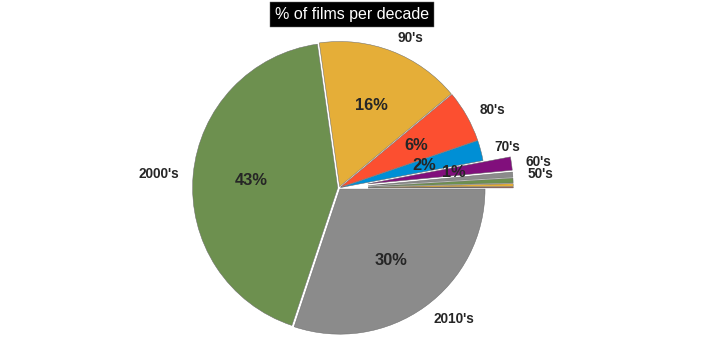

In [82]:
sns.set_context("poster", font_scale=0.85)
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

In [0]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
  genre_labels = genre_labels.union(set(s))

In [85]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [86]:
df_initial['genres'].unique()

array(['Action|Adventure|Fantasy|Science Fiction',
       'Adventure|Fantasy|Action', 'Action|Adventure|Crime', ...,
       'Thriller|Horror|Comedy', 'Foreign|Thriller',
       'Comedy|Drama|Romance|TV Movie'], dtype=object)

In [0]:
df_duplicate_cleaned = df_initial


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
